In [1]:
import numpy as np
import pickle
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# === 1. Load CIFAR-100 from local directory === #
base_path = 'cifar-100-python'

def load_cifar100_batch(file_name):
    with open(os.path.join(base_path, file_name), 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data['data'], data['fine_labels']

x_train, y_train = load_cifar100_batch('train')
x_test, y_test = load_cifar100_batch('test')

x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# === 2. Create tf.data pipeline with resize and preprocess === #
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image, label

batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).shuffle(50000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# === 3. Define the EfficientNetB0-based model === #
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='avg'
)
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dense(100, activation='softmax')  # 100 classes for CIFAR-100
])

model.summary()

# === 4. Compile model === #
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === 5. Set up callbacks === #
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('efficientnetb0_cifar100.keras', save_best_only=True)
]


# === 6. Train the model === #
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=callbacks
)







Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,756,743 (18.15 MB)

 Trainable params: 707,172 (2.70 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10


2025-04-24 13:56:26.614008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20213 of 50000
2025-04-24 13:56:36.637767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33298 of 50000
2025-04-24 13:56:46.558797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - accuracy: 0.4977 - loss: 2.0636 - val_accuracy: 0.6925 - val_loss: 1.0595
Epoch 2/10


2025-04-24 14:10:14.549264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20528 of 50000
2025-04-24 14:10:24.543957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36135 of 50000
2025-04-24 14:10:32.828623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.7201 - loss: 0.9622 - val_accuracy: 0.7193 - val_loss: 0.9690
Epoch 3/10


2025-04-24 14:25:01.840119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19665 of 50000
2025-04-24 14:25:21.740629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 41281 of 50000
2025-04-24 14:25:30.587262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - accuracy: 0.7640 - loss: 0.7951 - val_accuracy: 0.7268 - val_loss: 0.9367
Epoch 4/10


2025-04-24 14:39:36.342672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23099 of 50000
2025-04-24 14:39:56.362200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 43132 of 50000
2025-04-24 14:40:00.873797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.7933 - loss: 0.6911 - val_accuracy: 0.7305 - val_loss: 0.9366
Epoch 5/10


2025-04-24 14:52:45.189611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22722 of 50000
2025-04-24 14:53:03.496173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.8210 - loss: 0.5946 - val_accuracy: 0.7332 - val_loss: 0.9283
Epoch 6/10


2025-04-24 15:05:39.699214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22443 of 50000
2025-04-24 15:05:49.700256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 38689 of 50000
2025-04-24 15:05:56.694916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 796s 2s/step - accuracy: 0.8438 - loss: 0.5243 - val_accuracy: 0.7336 - val_loss: 0.9431
Epoch 7/10


2025-04-24 15:18:56.210738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22470 of 50000
2025-04-24 15:19:13.565083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 788s 2s/step - accuracy: 0.8632 - loss: 0.4588 - val_accuracy: 0.7324 - val_loss: 0.9599
Epoch 8/10


2025-04-24 15:32:04.207537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23571 of 50000
2025-04-24 15:32:14.269711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 38187 of 50000
2025-04-24 15:32:21.646333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 830s 2s/step - accuracy: 0.8783 - loss: 0.4046 - val_accuracy: 0.7340 - val_loss: 0.9607


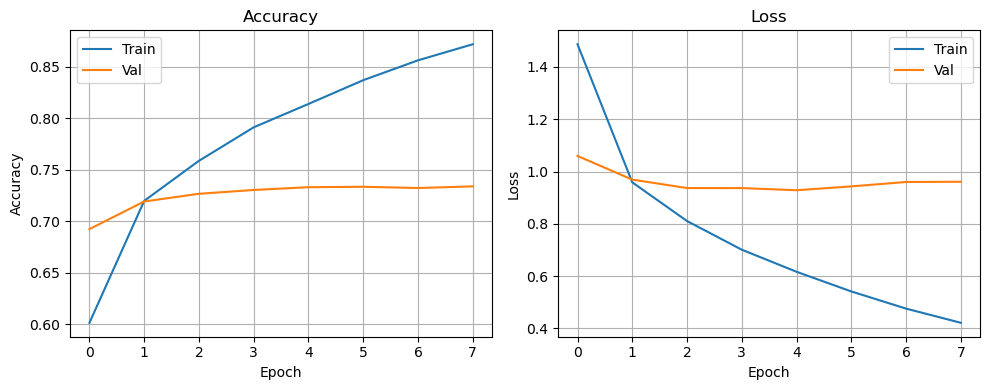

In [2]:
# === 8. Plot learning curves === #
plt.figure(figsize=(10, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()